In [49]:
import pandas as pd
import numpy as np
import math
import scipy.stats as stats
import xgboost as xgb
from sklearn.cross_validation import train_test_split
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error
import seaborn as sns
from sklearn.model_selection import KFold
import gc

In [50]:
label=pd.read_csv('ID_Gender_Age_datasets.csv')
label=label.drop('Unnamed: 0',axis=1)

In [51]:
ID_list=list(label['ID'])
file_name=['AutomaticExtractionData_IMUZCenter','ManualExtractionData/IMUZCenter','ManualExtractionData/IMUZRight',
          'ManualExtractionData/IMUZLeft','ManualExtractionData/Android']
action_name=['_Walk_1','_Walk_2','_SlopeDown','_SlopeUp']

In [52]:
# max,min,mean,mean_of_max_Npersent,mean_of_min_Npersent,stand_deviation,skewtest,kurtosis,the_lenth_of_dataset
def generate_features(df,percentage):
    ls_new=[]
    ls_name=[]
    col_name=list(df.columns.values)
    for c in col_name:
        df[c]=df[c].astype('float')
        ls=list(df[c].sort_values(ascending=False))
        max_value=ls[0]
        min_value=ls[-1]
        mean_of_max_Npersent=sum(ls[:math.floor(len(ls)*percentage)])/math.floor(len(ls)*percentage)
        mean_of_min_Npersent=sum(ls[-math.floor(len(ls)*percentage):-1])/math.floor(len(ls)*percentage)
        SD=np.std(np.array(ls), ddof = 1)
        skewtest=stats.skewtest(ls)[0]
        kurtosis=stats.kurtosis(ls)
        length=len(ls)
        ls_new=ls_new+[max_value,min_value,mean_of_max_Npersent,mean_of_min_Npersent,SD,skewtest,kurtosis]  
        ls_name=ls_name+['max_value'+'_'+c,'min_value'+'_'+c,'mean_of_max_Npersent'+'_'+c,'mean_of_min_Npersent'+'_'+c,
                         'SD'+'_'+c,'skewtest'+'_'+c,'kurtosis'+'_'+c] 
    ls_new=pd.DataFrame(ls_new).T
    ls_new.columns=ls_name
    return ls_new

In [53]:
def generate_read_table(fileName,actionName,ID,label): 
    try:
        dataset_name= fileName + actionName
        path_name= fileName +'/'+ str(label[label['ID']==ID][dataset_name].values[0])
        if fileName=='ManualExtractionData/Android':
            df=pd.read_csv(path_name,skiprows=2,dtype='float')
            df.columns=[0,0,0,df.columns.values[3],df.columns.values[4],df.columns.values[5]]
            insert_line=pd.DataFrame(df.columns.values).T
            df.columns=insert_line.columns
            df=pd.concat([insert_line,df],axis=0)
        else:
            df=pd.read_csv(path_name,skiprows=2,dtype='float')
            insert_line=pd.DataFrame(df.columns.values).T
            df.columns=insert_line.columns
            df=pd.concat([insert_line,df],axis=0)
        df.columns=['Gx','Gy','Gz','Ax','Ay','Az']
    except:
        df=pd.DataFrame(np.zeros(6)).T
        df.columns=['Gx','Gy','Gz','Ax','Ay','Az']
    return df

In [54]:
def generated_features_to_xgb(ID_list,label,fileName,actionName,percentage):
    dataframe=pd.DataFrame()
    for ID in ID_list:
        try:
            df=generate_read_table(fileName,actionName,ID,label)
            df=generate_features(df,percentage)
            df['Z_ID']=ID
            df['Z_Age']=label[label['ID']==ID]['Age'].values
            df['Z_Gender']=label[label['ID']==ID]['Gender(0:Female;1:Male)'].values
        except:
            df=pd.DataFrame(np.zeros(45)).T
            df.columns=dataframe.columns
        dataframe=pd.concat([dataframe,df],axis=0)
    return dataframe

In [81]:
def remove_dot(s):
    if type(s)==str and len(s)>4 and s[-2]=='.':
        s=float(s[:-2])
    return s

def kfold_XGB_Regressor(df, num_folds, X, y): 
    acc=[]
    kf = KFold(n_splits=num_folds)
    i=1
    feature_importance_df = pd.DataFrame()
    for train_index, test_index in kf.split(X):  
        X_train, X_test = X[train_index], X[test_index] 
        y_train, y_test = y[train_index], y[test_index]
        XGBR=xgb.XGBRegressor()
        XGBR.fit(X_train, y_train)
        y_pred1 = XGBR.predict(X_test)
        acc_score = mean_absolute_error(y_test,y_pred1)
        acc=acc+ list(y_pred1)
        print('Fold %2d MAE : %.6f' % (i, acc_score))
        print('******************************************')
        fold_importance_df = pd.DataFrame()
        fold_importance_df["feature"] = df.columns.values[:-3]
        fold_importance_df["importance"] = XGBR.feature_importances_
        fold_importance_df["fold"] = i
        feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
        i+=1

    full_mae=mean_absolute_error(y,acc)
    if full_mae<1000:
        print('Full MAE score %.6f' % full_mae)
    return feature_importance_df,full_mae

In [82]:
def display_importances(feature_importance_df_):
    cols = feature_importance_df_[["feature", "importance"]].groupby("feature").mean().sort_values(by="importance", ascending=False)[:20].index 
    best_features = feature_importance_df_.loc[feature_importance_df_.feature.isin(cols)] 
    plt.figure(figsize=(8, 10))
    sns.barplot(x="importance", y="feature",
    data=best_features.sort_values(by="importance", ascending=False)) 
    plt.title('XGBM Features (avg over folds)')
    plt.tight_layout
    plt.show()

In [89]:
def prediction(ID_list,label,file_name,action_name,percentage):
    ls_mae=[]
    for f in file_name:
        for a in action_name:
            try:
                df=generated_features_to_xgb(ID_list,label,f,a,percentage)
                df=df.dropna(axis=0)
                df.index = range(len(df))
                df=df.drop(df[df['Z_ID']==0].index,axis=0)
                y=df.values[:,-2]
                X=df.values[:,:-3]
                print('The dataset is from file: %s. The action is: %s'%(f,a[1:]))
                feature_importance_df_,full_mae=kfold_XGB_Regressor(df, 5, X, y)
                display_importances(feature_importance_df_)
                ls_mae.append(full_mae)
            except:
                print('There is no dataset from file: %s. The action is: %s'%(f,a[1:]))
    return ls_mae

The dataset is from file: AutomaticExtractionData_IMUZCenter. The action is: Walk_1
Fold  1 MAE : 11.631757
******************************************
Fold  2 MAE : 10.241328
******************************************
Fold  3 MAE : 12.151411
******************************************
Fold  4 MAE : 13.323294
******************************************
Fold  5 MAE : 11.331609
******************************************
Full MAE score 11.733725


/Users/liufangfei/anaconda/lib/python3.6/site-packages/seaborn/categorical.py:1428: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


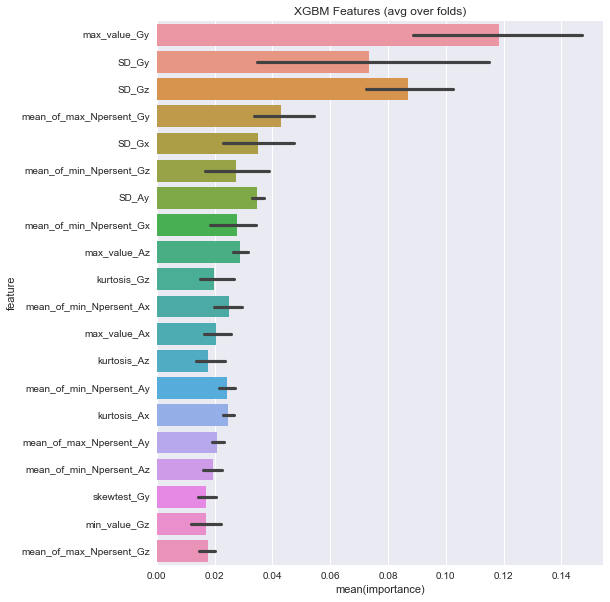

The dataset is from file: AutomaticExtractionData_IMUZCenter. The action is: Walk_2
Fold  1 MAE : 11.692588
******************************************
Fold  2 MAE : 9.987339
******************************************
Fold  3 MAE : 13.799854
******************************************
Fold  4 MAE : 13.193247
******************************************
Fold  5 MAE : 12.060475
******************************************
Full MAE score 12.146817


/Users/liufangfei/anaconda/lib/python3.6/site-packages/seaborn/categorical.py:1428: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


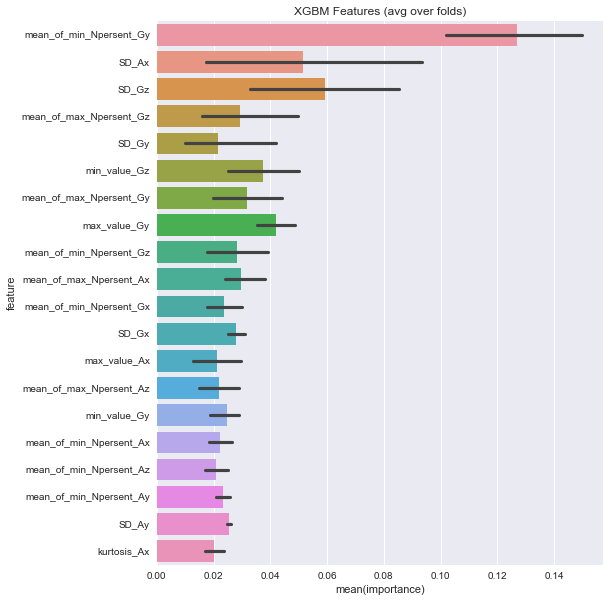

There is no dataset from file: AutomaticExtractionData_IMUZCenter. The action is: SlopeDown
There is no dataset from file: AutomaticExtractionData_IMUZCenter. The action is: SlopeUp
The dataset is from file: ManualExtractionData/IMUZCenter. The action is: Walk_1
Fold  1 MAE : 12.244734
******************************************
Fold  2 MAE : 10.436025
******************************************
Fold  3 MAE : 12.744793
******************************************
Fold  4 MAE : 13.262543
******************************************
Fold  5 MAE : 11.625754
******************************************
Full MAE score 12.062770


/Users/liufangfei/anaconda/lib/python3.6/site-packages/seaborn/categorical.py:1428: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


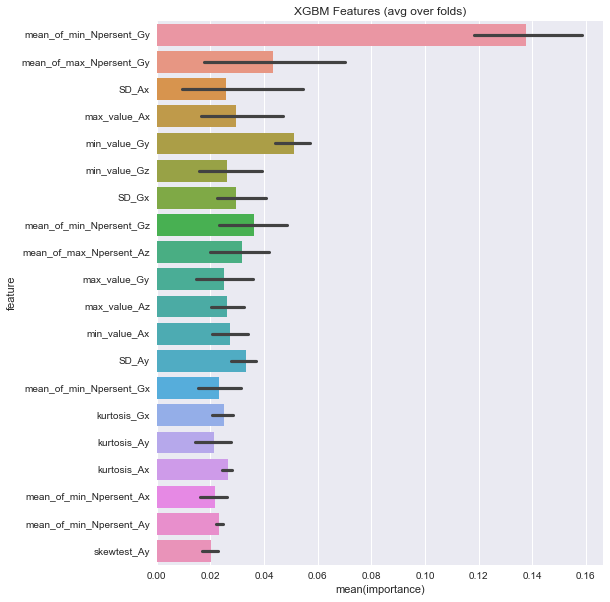

The dataset is from file: ManualExtractionData/IMUZCenter. The action is: Walk_2
Fold  1 MAE : 11.653502
******************************************
Fold  2 MAE : 11.440805
******************************************
Fold  3 MAE : 12.255089
******************************************
Fold  4 MAE : 12.522206
******************************************
Fold  5 MAE : 11.030341
******************************************
Full MAE score 11.781907


/Users/liufangfei/anaconda/lib/python3.6/site-packages/seaborn/categorical.py:1428: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


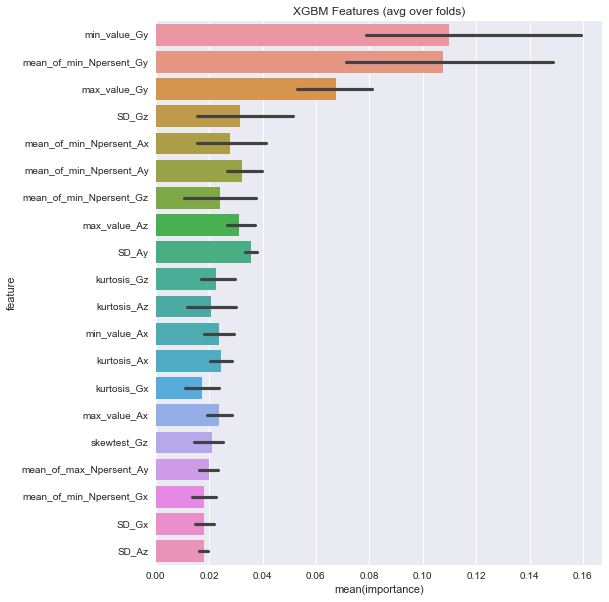

The dataset is from file: ManualExtractionData/IMUZCenter. The action is: SlopeDown
Fold  1 MAE : 11.034990
******************************************
Fold  2 MAE : 11.427689
******************************************
Fold  3 MAE : 12.524476
******************************************
Fold  4 MAE : 13.120635
******************************************
Fold  5 MAE : 10.907150
******************************************
Full MAE score 11.804802


/Users/liufangfei/anaconda/lib/python3.6/site-packages/seaborn/categorical.py:1428: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


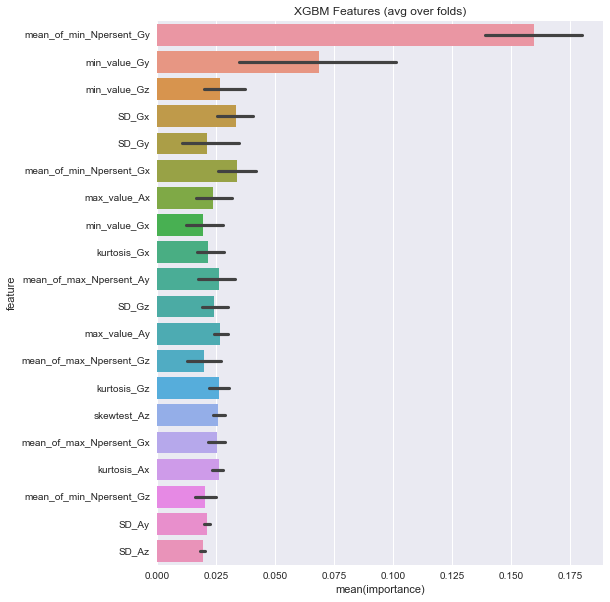

The dataset is from file: ManualExtractionData/IMUZCenter. The action is: SlopeUp
Fold  1 MAE : 9.796200
******************************************
Fold  2 MAE : 10.848204
******************************************
Fold  3 MAE : 13.141951
******************************************
Fold  4 MAE : 13.163104
******************************************
Fold  5 MAE : 10.476706
******************************************
Full MAE score 11.483861


/Users/liufangfei/anaconda/lib/python3.6/site-packages/seaborn/categorical.py:1428: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


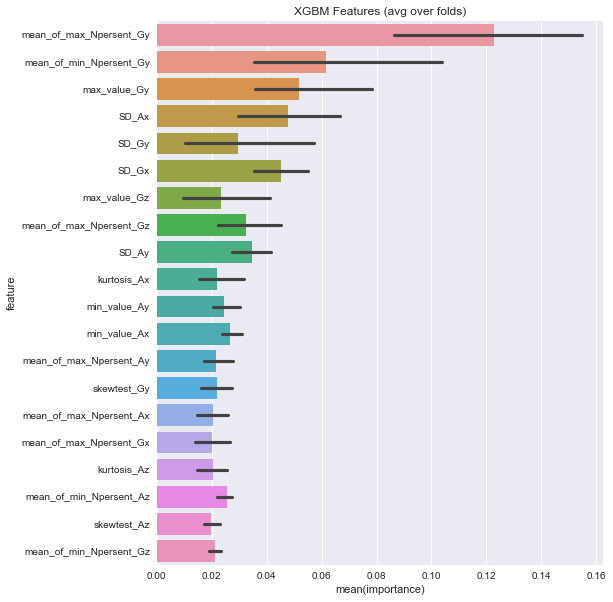

The dataset is from file: ManualExtractionData/IMUZRight. The action is: Walk_1
Fold  1 MAE : 10.946062
******************************************
Fold  2 MAE : 10.168581
******************************************
Fold  3 MAE : 13.324879
******************************************
Fold  4 MAE : 11.505461
******************************************
Fold  5 MAE : 9.193137
******************************************
Full MAE score 11.027624


/Users/liufangfei/anaconda/lib/python3.6/site-packages/seaborn/categorical.py:1428: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


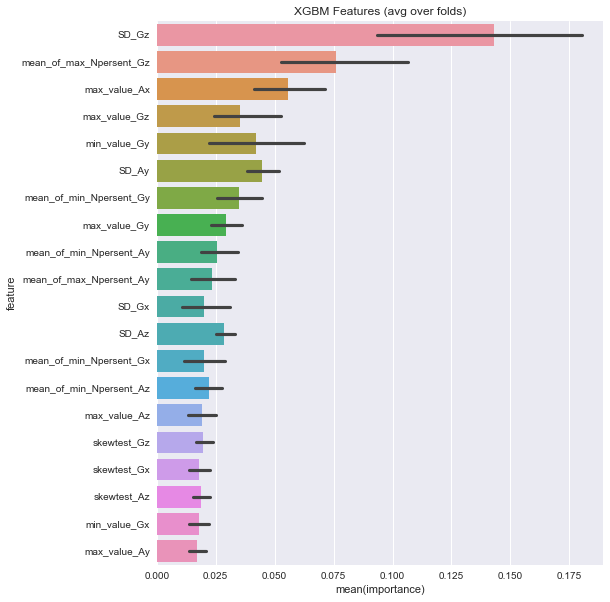

The dataset is from file: ManualExtractionData/IMUZRight. The action is: Walk_2
Fold  1 MAE : 9.626178
******************************************
Fold  2 MAE : 10.643023
******************************************
Fold  3 MAE : 12.421789
******************************************
Fold  4 MAE : 11.867488
******************************************
Fold  5 MAE : 9.040191
******************************************
Full MAE score 10.717436


/Users/liufangfei/anaconda/lib/python3.6/site-packages/seaborn/categorical.py:1428: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


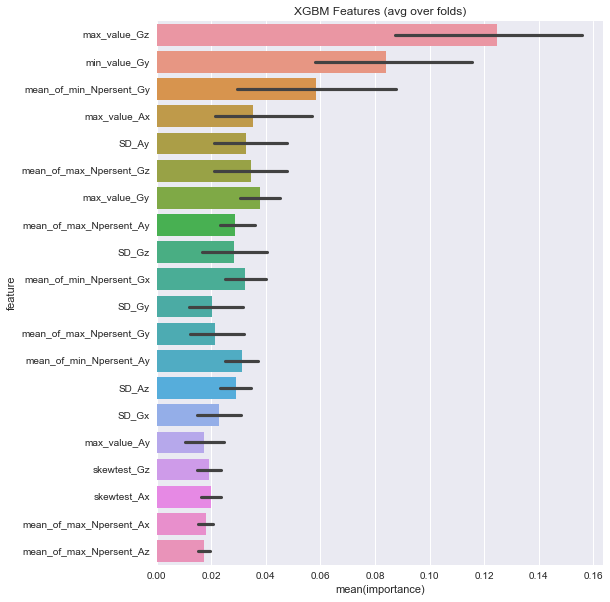

The dataset is from file: ManualExtractionData/IMUZRight. The action is: SlopeDown
Fold  1 MAE : 10.675659
******************************************
Fold  2 MAE : 10.213408
******************************************
Fold  3 MAE : 13.293455
******************************************
Fold  4 MAE : 12.064225
******************************************
Fold  5 MAE : 9.852501
******************************************
Full MAE score 11.218718


/Users/liufangfei/anaconda/lib/python3.6/site-packages/seaborn/categorical.py:1428: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


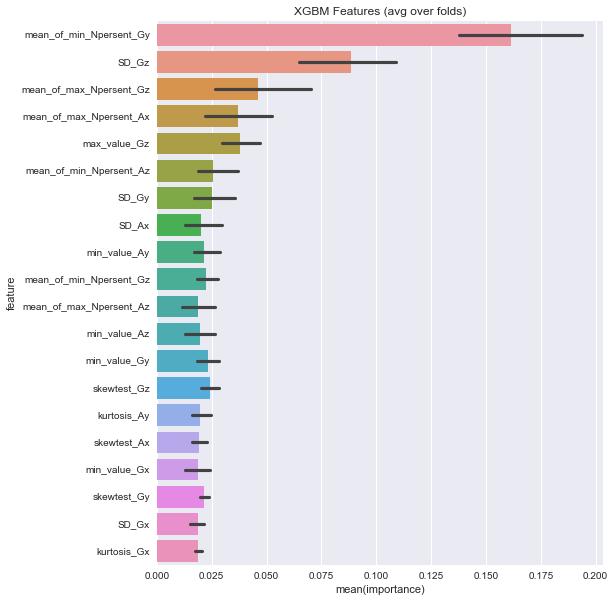

The dataset is from file: ManualExtractionData/IMUZRight. The action is: SlopeUp
Fold  1 MAE : 10.350071
******************************************
Fold  2 MAE : 11.163343
******************************************
Fold  3 MAE : 12.437035
******************************************
Fold  4 MAE : 12.371074
******************************************
Fold  5 MAE : 9.296059
******************************************
Full MAE score 11.124742


/Users/liufangfei/anaconda/lib/python3.6/site-packages/seaborn/categorical.py:1428: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


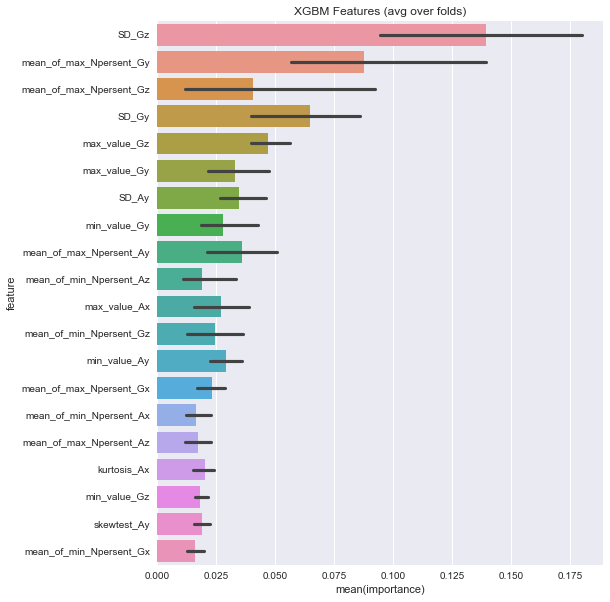

The dataset is from file: ManualExtractionData/IMUZLeft. The action is: Walk_1
Fold  1 MAE : 9.982890
******************************************
Fold  2 MAE : 10.221614
******************************************
Fold  3 MAE : 12.236104
******************************************
Fold  4 MAE : 11.558144
******************************************
Fold  5 MAE : 10.735867
******************************************
Full MAE score 10.947351


/Users/liufangfei/anaconda/lib/python3.6/site-packages/seaborn/categorical.py:1428: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


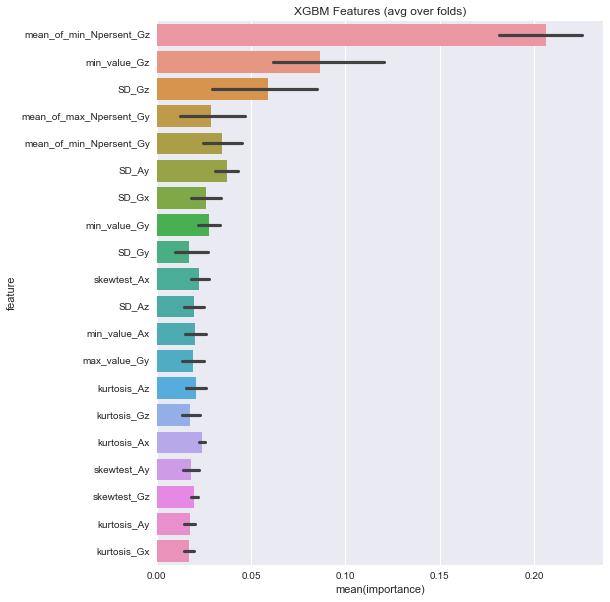

The dataset is from file: ManualExtractionData/IMUZLeft. The action is: Walk_2
Fold  1 MAE : 10.569908
******************************************
Fold  2 MAE : 10.133467
******************************************
Fold  3 MAE : 11.845168
******************************************
Fold  4 MAE : 10.425448
******************************************
Fold  5 MAE : 10.559586
******************************************
Full MAE score 10.707013


/Users/liufangfei/anaconda/lib/python3.6/site-packages/seaborn/categorical.py:1428: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


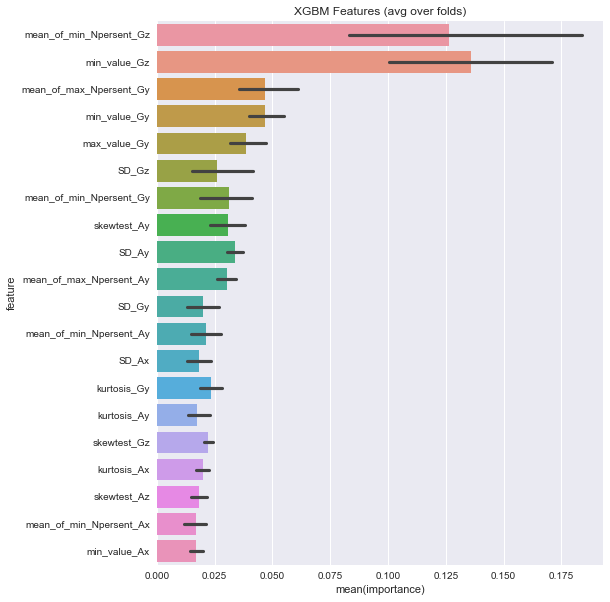

The dataset is from file: ManualExtractionData/IMUZLeft. The action is: SlopeDown
Fold  1 MAE : 11.069187
******************************************
Fold  2 MAE : 11.006467
******************************************
Fold  3 MAE : 12.714816
******************************************
Fold  4 MAE : 12.570190
******************************************
Fold  5 MAE : 10.955153
******************************************
Full MAE score 11.661953


/Users/liufangfei/anaconda/lib/python3.6/site-packages/seaborn/categorical.py:1428: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


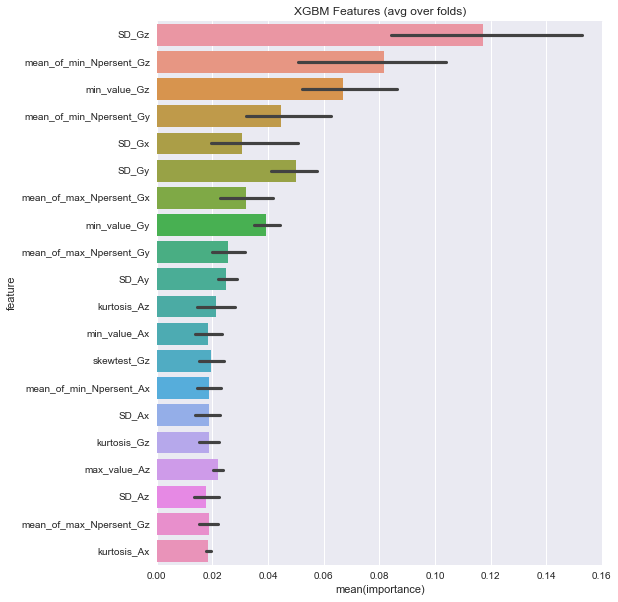

The dataset is from file: ManualExtractionData/IMUZLeft. The action is: SlopeUp
Fold  1 MAE : 10.187947
******************************************
Fold  2 MAE : 12.013319
******************************************
Fold  3 MAE : 11.707672
******************************************
Fold  4 MAE : 13.318340
******************************************
Fold  5 MAE : 10.130901
******************************************
Full MAE score 11.471636


/Users/liufangfei/anaconda/lib/python3.6/site-packages/seaborn/categorical.py:1428: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


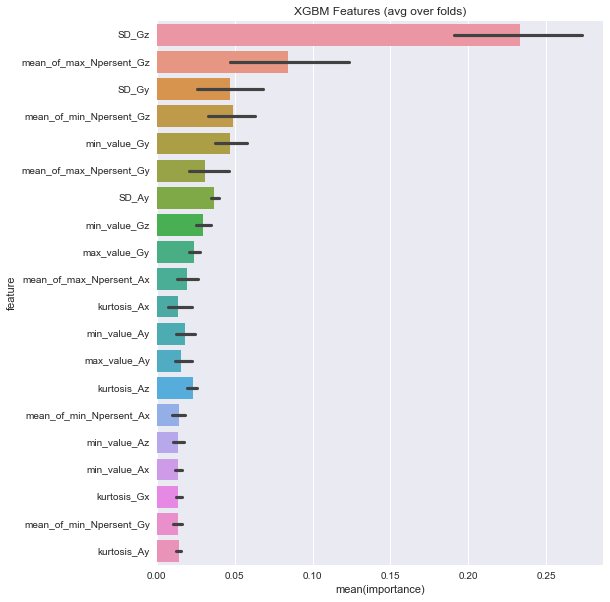

The dataset is from file: ManualExtractionData/Android. The action is: Walk_1
Fold  1 MAE : 12.234492
******************************************
Fold  2 MAE : 13.311412
******************************************
Fold  3 MAE : 12.585176
******************************************
Fold  4 MAE : 16.030976
******************************************
Fold  5 MAE : 11.910829
******************************************
Full MAE score 13.212163


/Users/liufangfei/anaconda/lib/python3.6/site-packages/seaborn/categorical.py:1428: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


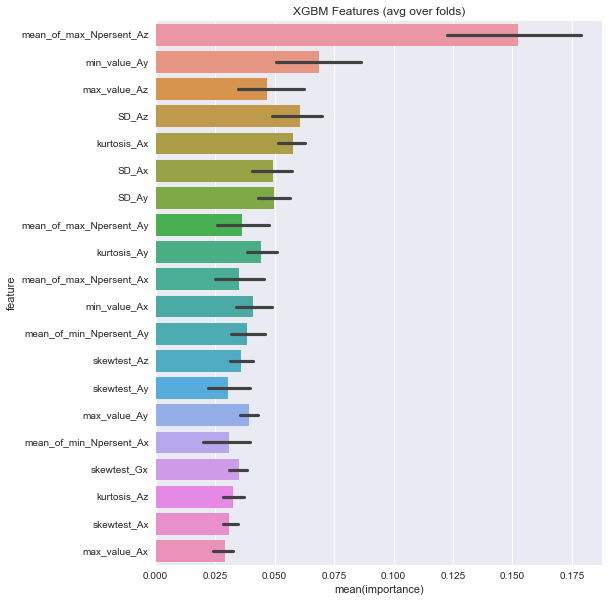

The dataset is from file: ManualExtractionData/Android. The action is: Walk_2
Fold  1 MAE : 11.821733
******************************************
Fold  2 MAE : 10.450720
******************************************
Fold  3 MAE : 14.006465
******************************************
Fold  4 MAE : 14.233903
******************************************
Fold  5 MAE : 11.900801
******************************************
Full MAE score 12.479858


/Users/liufangfei/anaconda/lib/python3.6/site-packages/seaborn/categorical.py:1428: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


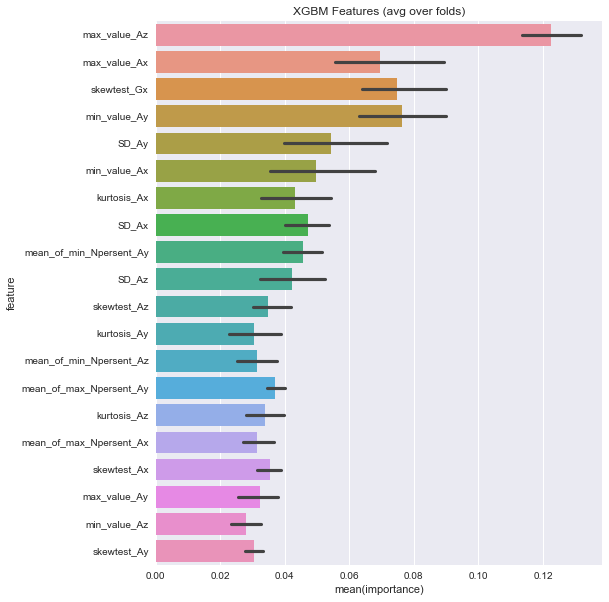

The dataset is from file: ManualExtractionData/Android. The action is: SlopeDown
Fold  1 MAE : 13.627197
******************************************
Fold  2 MAE : 13.472273
******************************************
Fold  3 MAE : 13.587793
******************************************
Fold  4 MAE : 14.555639
******************************************
Fold  5 MAE : 13.466487
******************************************
Full MAE score 13.740934


/Users/liufangfei/anaconda/lib/python3.6/site-packages/seaborn/categorical.py:1428: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


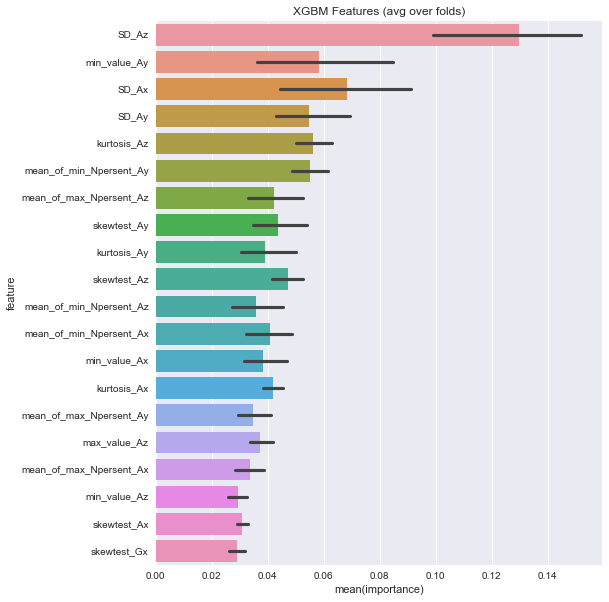

The dataset is from file: ManualExtractionData/Android. The action is: SlopeUp
Fold  1 MAE : 11.355243
******************************************
Fold  2 MAE : 12.087888
******************************************
Fold  3 MAE : 14.435903
******************************************
Fold  4 MAE : 14.008042
******************************************
Fold  5 MAE : 11.391327
******************************************
Full MAE score 12.652438


/Users/liufangfei/anaconda/lib/python3.6/site-packages/seaborn/categorical.py:1428: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


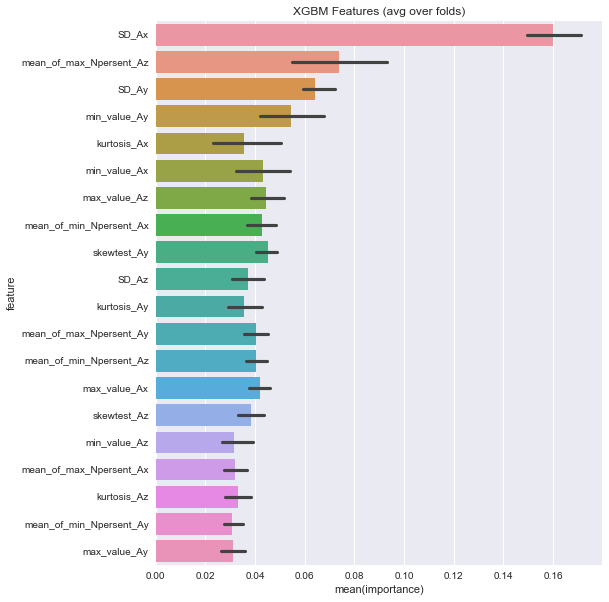

In [90]:
ls_mae=prediction(ID_list,label,file_name,action_name,0.05)

In [88]:
# np.savetxt("result_Selected_Features_XGBR_Age.txt", np.array(ls_mae))